###Installing Library

In [1]:
!pip install -q tensorflow
!pip install -q transformers
!pip install -q imblearn
!pip install -q scikit-learn
!pip install -q seaborn
!pip install -q pandas
!pip install -q gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 86.7 MB/s eta 0:00:00


###Import Library

In [2]:
import pandas as pd
import numpy as np
import gc
import os
import csv
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Transformers (Hugging Face)
from transformers import AutoTokenizer, TFAutoModel

# Scikit-learn
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report

# Imbalanced-learn
from imblearn.over_sampling import BorderlineSMOTE, KMeansSMOTE, SVMSMOTE

# Gensim
import gensim

os.environ["WANDB_DISABLED"] = "true"
tf.get_logger().setLevel('ERROR')

import warnings
warnings.filterwarnings('ignore')

###Read Dataset and load Word2Vec

In [3]:
df = pd.read_csv("/content/pilpres_train_balanced_clean.csv")

x_train = df['Text'].tolist()
y_train = df['Label'].values

print(f"Data loaded: {len(x_train)} samples")

Data loaded: 6274 samples


In [4]:
df_test = pd.read_csv("/content/pilpres_test_clean.csv")
x_test = df_test['Text'].tolist()
y_test = df_test['Label'].values
print(f"Test Data loaded: {len(x_test)} samples")

Test Data loaded: 384 samples


In [5]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
gc.collect()
print(gensim.__version__)
# Load Pretrained Word Embeddings (Word2Vec)
# !gdown --id 1QYj5FruufaPq2mZgC6lZlq2Uw2E004Og
# !gdown --id 1F9QsHO7FPIPq3nL_I0zCkZFvq3OVcJrB
# !gdown --id 1VUjxpH10baOw439V-YAAVVbtyI8iLgG5

4.4.0


In [6]:
import os
import gdown
import zipfile

'''https://drive.google.com/file/d/1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3/view?usp=sharing'''

file_id = '1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3'

url = f'https://drive.google.com/uc?id={file_id}'
output_zip = 'model_w2v.zip'

if not os.path.exists('idwiki_word2vec_768_new_lower.model'):
    print("Downloading Model...")
    gdown.download(url, output_zip, quiet=False)

    print("Extracting File...")
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Done.")
else:
    print("Model Available")


Downloading...
From (original): https://drive.google.com/uc?id=1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3
From (redirected): https://drive.google.com/uc?id=1R0Rq2oQEH4N1K7eXLvGkvKosR2rzxIw3&confirm=t&uuid=b2a26be5-84da-4578-861d-35896cfd4add
To: /content/model_w2v.zip
100%|██████████| 2.56G/2.56G [00:18<00:00, 139MB/s]


Extracting File...
Done.


In [7]:
WORD2VEC_MODEL_PATH = '/content/idwiki_word2vec_768_new_lower.model'

###Define Loss Function, Tokenization, Feature Extraction and Oversampling

In [8]:
# lambda_val = 0.7 # Lambda value for margin loss

In [9]:
MODEL_NAME = "indobenchmark/indobert-base-p2"
MAX_LENGTH = 256
BATCH_SIZE = 32
BATCH_SIZE_PREDICT = 32
epochs = 10
num_folds = 10
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

W2V_DIM = 768 # Dimensi Word2Vec
BERT_DIM = 768 # Dimensi BERT pooler output
COMBINED_DIM = W2V_DIM + BERT_DIM # 1536

In [10]:
# # Define the margin loss function
# def margin_loss(y_true, y_pred):
#     margin = K.constant(0.1)
#     y_true_float = K.cast(y_true, dtype='float32')
#     squared_difference_pos = K.square(K.maximum(0.9 - y_pred, 0))
#     squared_difference_neg = K.square(K.maximum(y_pred - 0.1, 0))
#     loss_pos = K.mean(y_true_float * squared_difference_pos)
#     loss_neg = K.mean((1 - y_true_float) * squared_difference_neg)
#     total_loss = loss_pos + lambda_val * loss_neg
#     return total_loss

In [11]:
def create_classifier_model(input_shape=(COMBINED_DIM,)):
    input_layer = Input(shape=input_shape)
    x = Dropout(0.3)(input_layer)
    output_layer = Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile
    optimizer = Adam(learning_rate=2e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [12]:
# Fungsi untuk Ekstraksi Word2Vec
def get_word2vec_embeddings(texts, word_embeddings, embedding_dim):
    text_embeddings = []

    for text in texts:
        text = str(text).lower()
        words = text.split()

        if word_embeddings is None:
             text_embeddings.append(np.zeros(embedding_dim))
             continue

        valid_words = [word for word in words if word in word_embeddings.wv]

        if valid_words:
            vectors = [word_embeddings.wv[word] for word in valid_words]
            text_embeddings.append(np.mean(vectors, axis=0))
        else:
            text_embeddings.append(np.zeros(embedding_dim))

    return np.array(text_embeddings)

####Feature Extraction

In [13]:
class BertModelLayer(Layer):
    def __init__(self, model_name, trainable=True, **kwargs):
        super().__init__(**kwargs)
        self.bert_model = TFAutoModel.from_pretrained(model_name)
        self.bert_model.trainable = trainable

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        bert_inputs = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_ids
        }
        outputs = self.bert_model(bert_inputs)
        return outputs.pooler_output

In [14]:
def create_feature_extractor(max_len=MAX_LENGTH):
    input_ids_layer = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask_layer = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')
    token_type_ids_layer = Input(shape=(max_len,), dtype=tf.int32, name='token_type_ids')

    bert_input_list = [input_ids_layer, attention_mask_layer, token_type_ids_layer]
    bert_layer = BertModelLayer(MODEL_NAME, trainable=False, name="bert_model_layer")
    cls_output = bert_layer(bert_input_list)

    model = Model(
        inputs=[input_ids_layer, attention_mask_layer, token_type_ids_layer],
        outputs=cls_output
    )
    return model

In [15]:
# Memuat Word2Vec
try:
    word_embeddings = gensim.models.Word2Vec.load(WORD2VEC_MODEL_PATH)
except FileNotFoundError:
    print(f"ERROR: Word2Vec model not found at {WORD2VEC_MODEL_PATH}. Using zero vectors for W2V features.")
    word_embeddings = None

In [16]:
gc.collect()

52

In [17]:
# Ekstraksi Fitur BERT
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encodings = tokenizer(
    [str(item) for item in x_train],
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors='tf'
)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [18]:
x_train_inputs_dict = {k: v for k, v in encodings.items()}

In [19]:
del encodings
gc.collect()

0

In [20]:
encodings_test = tokenizer(
    [str(item) for item in x_test],
    truncation=True,
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors='tf'
)
x_test_inputs_dict = {k: v for k, v in encodings_test.items()}
del encodings_test
gc.collect()

0

In [21]:
K.clear_session()
feature_extractor_model = create_feature_extractor()

tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for prediction

In [22]:
x_train_features_bert = feature_extractor_model.predict(
    x_train_inputs_dict,
    batch_size=BATCH_SIZE_PREDICT,
    verbose=1
)

197/197 ━━━━━━━━━━━━━━━━━━━━ 38s 157ms/step


In [23]:
x_test_features_bert = feature_extractor_model.predict(
    x_test_inputs_dict,
    batch_size=BATCH_SIZE_PREDICT,
    verbose=1
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


In [24]:
del feature_extractor_model, x_train_inputs_dict, x_test_inputs_dict
K.clear_session()
gc.collect()

0

In [25]:
# Ekstraksi dan Gabungan Fitur Word2Vec

In [26]:
x_train_features_w2v = get_word2vec_embeddings(x_train, word_embeddings, W2V_DIM)
x_test_features_w2v = get_word2vec_embeddings(x_test, word_embeddings, W2V_DIM)

del word_embeddings, x_train, x_test

In [27]:
x_train_features = np.concatenate((x_train_features_bert, x_train_features_w2v), axis=1)
print(f"Combined feature shape for SMOTE: {x_train_features.shape}")

Combined feature shape for SMOTE: (6274, 1536)


In [28]:
x_test_features = np.concatenate((x_test_features_bert, x_test_features_w2v), axis=1)
print(f"Combined Test feature shape: {x_test_features.shape}")

Combined Test feature shape: (384, 1536)


In [29]:
del x_train_features_bert, x_train_features_w2v, x_test_features_bert, x_test_features_w2v
gc.collect()

0

####Oversampling with BorderlineSMOTE

In [30]:
borderline_smote = BorderlineSMOTE(random_state=42)
x_res_features_border, y_res_border = borderline_smote.fit_resample(x_train_features, y_train)
print(f"BorderlineSMOTE data shape: {x_res_features_border.shape}")

BorderlineSMOTE data shape: (6274, 1536)


####Oversampling with KMeansSMOTE

In [31]:
kmeans_smote = KMeansSMOTE(random_state=42, cluster_balance_threshold=0.2)
x_res_features_kmeans, y_res_kmeans = kmeans_smote.fit_resample(x_train_features, y_train)
print(f"KMeansSMOTE data shape: {x_res_features_kmeans.shape}")

KMeansSMOTE data shape: (6274, 1536)


####Oversampling with SVMSMOTE

In [32]:
svm_smote = SVMSMOTE(random_state=42)
x_res_features_svm, y_res_svm = svm_smote.fit_resample(x_train_features, y_train)
print(f"SVMSMOTE data shape: {x_res_features_svm.shape}")

SVMSMOTE data shape: (6274, 1536)


In [33]:
# del x_train_features, y_train
gc.collect()

0

##IndoBERT Model

###IndoBERT BorderlineSMOTE

In [34]:
x_train_np = np.array(x_res_features_border)
y_train_np = np.array(y_res_border)

In [35]:
temp_model_border = create_classifier_model()
history_borderline = temp_model_border.fit(
    x_train_np,
    y_train_np,
    batch_size=BATCH_SIZE,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

final_model_borderline = temp_model_border
gc.collect()

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6165 - loss: 0.6436 - val_accuracy: 0.6067 - val_loss: 0.6869
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7218 - loss: 0.5297 - val_accuracy: 0.7659 - val_loss: 0.5245
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7509 - loss: 0.4887 - val_accuracy: 0.8854 - val_loss: 0.4012
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7869 - loss: 0.4511 - val_accuracy: 0.8662 - val_loss: 0.4078
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7772 - loss: 0.4608 - val_accuracy: 0.8217 - val_loss: 0.4574
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7906 - loss: 0.4383 - val_accuracy: 0.8949 - val_loss: 0.3548
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7830 - loss: 0.4516 - val_accuracy: 0.6975 - val_loss: 0.5295
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7942 - loss: 0.4377 - val_accuracy: 0

712

####Cross-Validation Train

In [36]:
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

train_accuracies, val_accuracies, train_losses, val_losses = [], [], [], []
classification_reports_list = []

fold = 0
for train_indices, val_indices in kf.split(y_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds} (BorderlineSMOTE)")

    K.clear_session()
    model_fold = create_classifier_model()

    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Train model
    model_fold.fit(
        x_train_fold,
        y_train_fold,
        batch_size=BATCH_SIZE,
        epochs=epochs,
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
        verbose=0
    )

    train_loss, train_accuracy = model_fold.evaluate(x_train_fold, y_train_fold, verbose=0)
    val_loss, val_accuracy = model_fold.evaluate(x_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold} - Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    train_accuracies.append(train_accuracy); val_accuracies.append(val_accuracy)
    train_losses.append(train_loss); val_losses.append(val_loss)

    y_pred_prob = model_fold.predict(x_val_fold, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
    report = classification_report(y_val_fold, y_pred, output_dict=True, zero_division=0)
    classification_reports_list.append(report)
    print("-" * 30)

    del model_fold
    gc.collect()

Training fold 1/10 (BorderlineSMOTE)
Fold 1 - Train Acc: 0.8645, Val Acc: 0.8328
------------------------------
Training fold 2/10 (BorderlineSMOTE)
Fold 2 - Train Acc: 0.8463, Val Acc: 0.8312
------------------------------
Training fold 3/10 (BorderlineSMOTE)
Fold 3 - Train Acc: 0.8528, Val Acc: 0.8169
------------------------------
Training fold 4/10 (BorderlineSMOTE)
Fold 4 - Train Acc: 0.8448, Val Acc: 0.8328
------------------------------
Training fold 5/10 (BorderlineSMOTE)
Fold 5 - Train Acc: 0.8580, Val Acc: 0.8230
------------------------------
Training fold 6/10 (BorderlineSMOTE)
Fold 6 - Train Acc: 0.8528, Val Acc: 0.8230
------------------------------
Training fold 7/10 (BorderlineSMOTE)
Fold 7 - Train Acc: 0.8574, Val Acc: 0.8325
------------------------------
Training fold 8/10 (BorderlineSMOTE)
Fold 8 - Train Acc: 0.8520, Val Acc: 0.8325
------------------------------
Training fold 9/10 (BorderlineSMOTE)
Fold 9 - Train Acc: 0.8592, Val Acc: 0.8293
-----------------------

In [37]:
print(f"Mean Training Accuracy: {np.mean(train_accuracies):.4f} (Std: {np.std(train_accuracies):.4f})")
print(f"Mean Training Loss: {np.mean(train_losses):.4f} (Std: {np.std(train_losses):.4f})")
print(f"Mean Validation Accuracy: {np.mean(val_accuracies):.4f} (Std: {np.std(val_accuracies):.4f})")
print(f"Mean Validation Loss: {np.mean(val_losses):.4f} (Std: {np.std(val_losses):.4f})")

Mean Training Accuracy: 0.8545 (Std: 0.0057)
Mean Training Loss: 0.3650 (Std: 0.0044)
Mean Validation Accuracy: 0.8314 (Std: 0.0108)
Mean Validation Loss: 0.3999 (Std: 0.0173)


In [38]:
if classification_reports_list:
    avg_report = {
        '0': { # Menggunakan '0' dan '1' (string) sesuai output dict classification_report
            'precision': np.mean([r['0']['precision'] for r in classification_reports_list if '0' in r]),
            'recall': np.mean([r['0']['recall'] for r in classification_reports_list if '0' in r]),
            'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_list if '0' in r]),
            'support': np.sum([r['0']['support'] for r in classification_reports_list if '0' in r])
        },
        '1': { # Menggunakan '0' dan '1' (string)
            'precision': np.mean([r['1']['precision'] for r in classification_reports_list if '1' in r]),
            'recall': np.mean([r['1']['recall'] for r in classification_reports_list if '1' in r]),
            'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_list if '1' in r]),
            'support': np.sum([r['1']['support'] for r in classification_reports_list if '1' in r])
        },
        'accuracy': np.mean([r['accuracy'] for r in classification_reports_list if 'accuracy' in r]),
        'macro avg': {
            'precision': np.mean([r['macro avg']['precision'] for r in classification_reports_list if 'macro avg' in r]),
            'recall': np.mean([r['macro avg']['recall'] for r in classification_reports_list if 'macro avg' in r]),
            'f1-score': np.mean([r['macro avg']['f1-score'] for r in classification_reports_list if 'macro avg' in r]),
        },
        'weighted avg': {
            'precision': np.mean([r['weighted avg']['precision'] for r in classification_reports_list if 'weighted avg' in r]),
            'recall': np.mean([r['weighted avg']['recall'] for r in classification_reports_list if 'weighted avg' in r]),
            'f1-score': np.mean([r['weighted avg']['f1-score'] for r in classification_reports_list if 'weighted avg' in r]),
        }
    }

    # Print the aggregated classification report
    print("Average Classification Report across all folds:")
    import json
    print(json.dumps(avg_report, indent=2))
else:
    print("No classification reports were generated.")

Average Classification Report across all folds:
{
  "0": {
    "precision": 0.8898766159918194,
    "recall": 0.759674307916716,
    "f1-score": 0.817544273745694,
    "support": 3137.0
  },
  "1": {
    "precision": 0.7923172229386497,
    "recall": 0.9015130544728924,
    "f1-score": 0.8419406921029717,
    "support": 3137.0
  },
  "accuracy": 0.8313694267515924,
  "macro avg": {
    "precision": 0.8410969194652347,
    "recall": 0.8305936811948043,
    "f1-score": 0.829742482924333
  },
  "weighted avg": {
    "precision": 0.8409183588786089,
    "recall": 0.8313694267515924,
    "f1-score": 0.8300579292575494
  }
}


In [39]:
csv_file = 'metrics_IndoBERT_BorderlineSMOTE.csv'
headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']
all_metrics = []
num_epochs_ran = len(history_borderline.history['loss'])

for epoch in range(num_epochs_ran):
    train_loss = history_borderline.history['loss'][epoch]
    train_accuracy = history_borderline.history['accuracy'][epoch]
    val_loss = history_borderline.history['val_loss'][epoch]
    val_accuracy = history_borderline.history['val_accuracy'][epoch]
    all_metrics.append([epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy])

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(all_metrics)
print(f"Metrics saved to {csv_file}")

Metrics saved to metrics_IndoBERT_BorderlineSMOTE.csv


####Testing

In [40]:
y_test_pred_borderline = (final_model_borderline.predict(x_test_features) > 0.5).astype("int32").flatten()

test_report_borderline = classification_report(y_test, y_test_pred_borderline)

print("Classification Report on Test Dataset 1 (BorderlineSMOTE):")
print(test_report_borderline)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Classification Report on Test Dataset 1 (BorderlineSMOTE):
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       349
           1       0.26      0.80      0.39        35

    accuracy                           0.77       384
   macro avg       0.62      0.79      0.63       384
weighted avg       0.91      0.77      0.82       384



###IndoBERT KMeansSMOTE

In [41]:
x_train_np = np.array(x_res_features_kmeans)
y_train_np = np.array(y_res_kmeans)
del x_res_features_kmeans, y_res_kmeans
gc.collect()

300

In [42]:
temp_model_kmeans = create_classifier_model()
history_kmeans = temp_model_kmeans.fit(
    x_train_np,
    y_train_np,
    batch_size=BATCH_SIZE,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

final_model_kmeans = temp_model_kmeans
gc.collect()

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6246 - loss: 0.6331 - val_accuracy: 0.7102 - val_loss: 0.6059
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7251 - loss: 0.5283 - val_accuracy: 0.6290 - val_loss: 0.6635
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7533 - loss: 0.4864 - val_accuracy: 0.9283 - val_loss: 0.3362
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7661 - loss: 0.4682 - val_accuracy: 0.8885 - val_loss: 0.4004
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7764 - loss: 0.4586 - val_accuracy: 0.8217 - val_loss: 0.4478
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7819 - loss: 0.4473 - val_accuracy: 0.3790 - val_loss: 0.9282


4093

####Cross-Validation Train

In [43]:
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
train_accuracies, val_accuracies, train_losses, val_losses = [], [], [], []
classification_reports_list = []

fold = 0
for train_indices, val_indices in kf.split(y_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds} (KMeansSMOTE)")

    K.clear_session()
    model_fold = create_classifier_model()

    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Train model
    model_fold.fit(
        x_train_fold,
        y_train_fold,
        batch_size=BATCH_SIZE,
        epochs=epochs,
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
        verbose=0
    )

    train_loss, train_accuracy = model_fold.evaluate(x_train_fold, y_train_fold, verbose=0)
    val_loss, val_accuracy = model_fold.evaluate(x_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold} - Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    y_pred_prob = model_fold.predict(x_val_fold, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
    report = classification_report(y_val_fold, y_pred, output_dict=True, zero_division=0)
    classification_reports_list.append(report)
    print("-" * 30)

    del model_fold
    gc.collect()

Training fold 1/10 (KMeansSMOTE)
Fold 1 - Train Acc: 0.8502, Val Acc: 0.8264
------------------------------
Training fold 2/10 (KMeansSMOTE)
Fold 2 - Train Acc: 0.8557, Val Acc: 0.8424
------------------------------
Training fold 3/10 (KMeansSMOTE)
Fold 3 - Train Acc: 0.8611, Val Acc: 0.8169
------------------------------
Training fold 4/10 (KMeansSMOTE)
Fold 4 - Train Acc: 0.8521, Val Acc: 0.8503
------------------------------
Training fold 5/10 (KMeansSMOTE)
Fold 5 - Train Acc: 0.8410, Val Acc: 0.8102
------------------------------
Training fold 6/10 (KMeansSMOTE)
Fold 6 - Train Acc: 0.8583, Val Acc: 0.8262
------------------------------
Training fold 7/10 (KMeansSMOTE)
Fold 7 - Train Acc: 0.8635, Val Acc: 0.8357
------------------------------
Training fold 8/10 (KMeansSMOTE)
Fold 8 - Train Acc: 0.8165, Val Acc: 0.8166
------------------------------
Training fold 9/10 (KMeansSMOTE)
Fold 9 - Train Acc: 0.8585, Val Acc: 0.8278
------------------------------
Training fold 10/10 (KMeansS

In [44]:
print(f"Mean Training Accuracy: {np.mean(train_accuracies):.4f} (Std: {np.std(train_accuracies):.4f})")
print(f"Mean Training Loss: {np.mean(train_losses):.4f} (Std: {np.std(train_losses):.4f})")
print(f"Mean Validation Accuracy: {np.mean(val_accuracies):.4f} (Std: {np.std(val_accuracies):.4f})")
print(f"Mean Validation Loss: {np.mean(val_losses):.4f} (Std: {np.std(val_losses):.4f})")

Mean Training Accuracy: 0.8515 (Std: 0.0131)
Mean Training Loss: 0.3694 (Std: 0.0207)
Mean Validation Accuracy: 0.8302 (Std: 0.0133)
Mean Validation Loss: 0.4008 (Std: 0.0182)


In [45]:
if classification_reports_list:
    avg_report = {
        '0': {
            'precision': np.mean([r['0']['precision'] for r in classification_reports_list if '0' in r]),
            'recall': np.mean([r['0']['recall'] for r in classification_reports_list if '0' in r]),
            'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_list if '0' in r]),
            'support': np.sum([r['0']['support'] for r in classification_reports_list if '0' in r])
        },
        '1': {
            'precision': np.mean([r['1']['precision'] for r in classification_reports_list if '1' in r]),
            'recall': np.mean([r['1']['recall'] for r in classification_reports_list if '1' in r]),
            'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_list if '1' in r]),
            'support': np.sum([r['1']['support'] for r in classification_reports_list if '1' in r])
        },
        'accuracy': np.mean([r['accuracy'] for r in classification_reports_list if 'accuracy' in r]),
        'macro avg': {
            'precision': np.mean([r['macro avg']['precision'] for r in classification_reports_list if 'macro avg' in r]),
            'recall': np.mean([r['macro avg']['recall'] for r in classification_reports_list if 'macro avg' in r]),
            'f1-score': np.mean([r['macro avg']['f1-score'] for r in classification_reports_list if 'macro avg' in r]),
        },
        'weighted avg': {
            'precision': np.mean([r['weighted avg']['precision'] for r in classification_reports_list if 'weighted avg' in r]),
            'recall': np.mean([r['weighted avg']['recall'] for r in classification_reports_list if 'weighted avg' in r]),
            'f1-score': np.mean([r['weighted avg']['f1-score'] for r in classification_reports_list if 'weighted avg' in r]),
        }
    }
    print("Average Classification Report across all folds (KMeansSMOTE):")
    import json
    print(json.dumps(avg_report, indent=2))
else:
    print("No classification reports were generated.")

Average Classification Report across all folds (KMeansSMOTE):
{
  "0": {
    "precision": 0.8732762189896691,
    "recall": 0.776078877855873,
    "f1-score": 0.8199897712484974,
    "support": 3137.0
  },
  "1": {
    "precision": 0.7995527283589031,
    "recall": 0.8843051295628355,
    "f1-score": 0.838648438872406,
    "support": 3137.0
  },
  "accuracy": 0.8302494438179989,
  "macro avg": {
    "precision": 0.836414473674286,
    "recall": 0.8301920037093542,
    "f1-score": 0.8293191050604518
  },
  "weighted avg": {
    "precision": 0.8366819531854744,
    "recall": 0.8302494438179989,
    "f1-score": 0.8294967511348297
  }
}


In [46]:
# Simpan Metrik ke CSV
csv_file = 'metrics_IndoBERT_KMeansSMOTE.csv'
headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']
all_metrics = []
num_epochs_ran = len(history_kmeans.history['loss'])

for epoch in range(num_epochs_ran):
    all_metrics.append([
        epoch + 1,
        history_kmeans.history['loss'][epoch],
        history_kmeans.history['accuracy'][epoch],
        history_kmeans.history['val_loss'][epoch],
        history_kmeans.history['val_accuracy'][epoch]
    ])

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(all_metrics)
print(f"Metrics saved to {csv_file}")

Metrics saved to metrics_IndoBERT_KMeansSMOTE.csv


####Testing

In [47]:
y_test_pred_kmeans = (final_model_kmeans.predict(x_test_features) > 0.5).astype("int32").flatten()

test_report_kmeans = classification_report(y_test, y_test_pred_kmeans)

print("Classification Report on Test Dataset 1 (kmeansSMOTE):")
print(test_report_kmeans)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Classification Report on Test Dataset 1 (kmeansSMOTE):
              precision    recall  f1-score   support

           0       0.98      0.68      0.81       349
           1       0.22      0.89      0.35        35

    accuracy                           0.70       384
   macro avg       0.60      0.79      0.58       384
weighted avg       0.91      0.70      0.77       384



###IndoBERT SVMSMOTE

In [48]:
x_train_np = np.array(x_res_features_svm)
y_train_np = np.array(y_res_svm)
del x_res_features_svm, y_res_svm
gc.collect()

300

In [49]:
temp_model_svm = create_classifier_model()
history_svm = temp_model_svm.fit(
    x_train_np,
    y_train_np,
    batch_size=BATCH_SIZE,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

final_model_svm = temp_model_svm
gc.collect()

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6313 - loss: 0.6488 - val_accuracy: 0.5191 - val_loss: 0.7513
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7215 - loss: 0.5169 - val_accuracy: 0.7118 - val_loss: 0.6237
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7501 - loss: 0.5058 - val_accuracy: 0.8201 - val_loss: 0.4636
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7741 - loss: 0.4733 - val_accuracy: 0.9029 - val_loss: 0.3528
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7634 - loss: 0.4659 - val_accuracy: 0.8901 - val_loss: 0.3749
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7905 - loss: 0.4359 - val_accuracy: 0.8662 - val_loss: 0.4222
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7761 - loss: 0.4483 - val_accuracy: 0.9299 - val_loss: 0.3301
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7901 - loss: 0.4410 - val_accuracy: 0

4093

####Cross-Validation Train

In [50]:
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
train_accuracies, val_accuracies, train_losses, val_losses = [], [], [], []
classification_reports_list = []

fold = 0
for train_indices, val_indices in kf.split(y_train_np):
    fold += 1
    print(f"Training fold {fold}/{num_folds} (SVMSMOTE)")

    K.clear_session()
    model_fold = create_classifier_model()

    x_train_fold = x_train_np[train_indices]
    y_train_fold = y_train_np[train_indices]
    x_val_fold = x_train_np[val_indices]
    y_val_fold = y_train_np[val_indices]

    # Train model
    model_fold.fit(
        x_train_fold,
        y_train_fold,
        batch_size=BATCH_SIZE,
        epochs=epochs,
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[early_stopping],
        verbose=0
    )

    train_loss, train_accuracy = model_fold.evaluate(x_train_fold, y_train_fold, verbose=0)
    val_loss, val_accuracy = model_fold.evaluate(x_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold} - Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    y_pred_prob = model_fold.predict(x_val_fold, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
    report = classification_report(y_val_fold, y_pred, output_dict=True, zero_division=0)
    classification_reports_list.append(report)
    print("-" * 30)

    del model_fold
    gc.collect()

Training fold 1/10 (SVMSMOTE)
Fold 1 - Train Acc: 0.8578, Val Acc: 0.8312
------------------------------
Training fold 2/10 (SVMSMOTE)
Fold 2 - Train Acc: 0.8518, Val Acc: 0.8392
------------------------------
Training fold 3/10 (SVMSMOTE)
Fold 3 - Train Acc: 0.8581, Val Acc: 0.8121
------------------------------
Training fold 4/10 (SVMSMOTE)
Fold 4 - Train Acc: 0.8537, Val Acc: 0.8455
------------------------------
Training fold 5/10 (SVMSMOTE)
Fold 5 - Train Acc: 0.8546, Val Acc: 0.8278
------------------------------
Training fold 6/10 (SVMSMOTE)
Fold 6 - Train Acc: 0.8486, Val Acc: 0.8086
------------------------------
Training fold 7/10 (SVMSMOTE)
Fold 7 - Train Acc: 0.8541, Val Acc: 0.8230
------------------------------
Training fold 8/10 (SVMSMOTE)
Fold 8 - Train Acc: 0.8392, Val Acc: 0.8453
------------------------------
Training fold 9/10 (SVMSMOTE)
Fold 9 - Train Acc: 0.8534, Val Acc: 0.8182
------------------------------
Training fold 10/10 (SVMSMOTE)
Fold 10 - Train Acc: 0.8

In [51]:
print(f"Mean Training Accuracy: {np.mean(train_accuracies):.4f} (Std: {np.std(train_accuracies):.4f})")
print(f"Mean Training Loss: {np.mean(train_losses):.4f} (Std: {np.std(train_losses):.4f})")
print(f"Mean Validation Accuracy: {np.mean(val_accuracies):.4f} (Std: {np.std(val_accuracies):.4f})")
print(f"Mean Validation Loss: {np.mean(val_losses):.4f} (Std: {np.std(val_losses):.4f})")

Mean Training Accuracy: 0.8528 (Std: 0.0053)
Mean Training Loss: 0.3659 (Std: 0.0044)
Mean Validation Accuracy: 0.8310 (Std: 0.0155)
Mean Validation Loss: 0.3952 (Std: 0.0128)


In [52]:
if classification_reports_list:
    avg_report = {
        '0': {
            'precision': np.mean([r['0']['precision'] for r in classification_reports_list if '0' in r]),
            'recall': np.mean([r['0']['recall'] for r in classification_reports_list if '0' in r]),
            'f1-score': np.mean([r['0']['f1-score'] for r in classification_reports_list if '0' in r]),
            'support': np.sum([r['0']['support'] for r in classification_reports_list if '0' in r])
        },
        '1': {
            'precision': np.mean([r['1']['precision'] for r in classification_reports_list if '1' in r]),
            'recall': np.mean([r['1']['recall'] for r in classification_reports_list if '1' in r]),
            'f1-score': np.mean([r['1']['f1-score'] for r in classification_reports_list if '1' in r]),
            'support': np.sum([r['1']['support'] for r in classification_reports_list if '1' in r])
        },
        'accuracy': np.mean([r['accuracy'] for r in classification_reports_list if 'accuracy' in r]),
        'macro avg': {
            'precision': np.mean([r['macro avg']['precision'] for r in classification_reports_list if 'macro avg' in r]),
            'recall': np.mean([r['macro avg']['recall'] for r in classification_reports_list if 'macro avg' in r]),
            'f1-score': np.mean([r['macro avg']['f1-score'] for r in classification_reports_list if 'macro avg' in r]),
        },
        'weighted avg': {
            'precision': np.mean([r['weighted avg']['precision'] for r in classification_reports_list if 'weighted avg' in r]),
            'recall': np.mean([r['weighted avg']['recall'] for r in classification_reports_list if 'weighted avg' in r]),
            'f1-score': np.mean([r['weighted avg']['f1-score'] for r in classification_reports_list if 'weighted avg' in r]),
        }
    }
    print("Average Classification Report across all folds (SVMSMOTE):")
    import json
    print(json.dumps(avg_report, indent=2))
else:
    print("No classification reports were generated.")

Average Classification Report across all folds (SVMSMOTE):
{
  "0": {
    "precision": 0.8798337840000681,
    "recall": 0.7687056542147161,
    "f1-score": 0.8189520417537691,
    "support": 3137.0
  },
  "1": {
    "precision": 0.7966538650430033,
    "recall": 0.8907515932996525,
    "f1-score": 0.8401674367930342,
    "support": 3137.0
  },
  "accuracy": 0.8310481618057883,
  "macro avg": {
    "precision": 0.8382438245215358,
    "recall": 0.8297286237571843,
    "f1-score": 0.8295597392734017
  },
  "weighted avg": {
    "precision": 0.8376688353838023,
    "recall": 0.8310481618057883,
    "f1-score": 0.8299626239219207
  }
}


In [53]:
# Simpan Metrik ke CSV
csv_file = 'metrics_IndoBERT_SVMSMOTE.csv'
headers = ['epoch', 'train_loss', 'train_accuracy', 'val_loss', 'val_accuracy']
all_metrics = []
num_epochs_ran = len(history_svm.history['loss'])

for epoch in range(num_epochs_ran):
    all_metrics.append([
        epoch + 1,
        history_svm.history['loss'][epoch],
        history_svm.history['accuracy'][epoch],
        history_svm.history['val_loss'][epoch],
        history_svm.history['val_accuracy'][epoch]
    ])

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    writer.writerows(all_metrics)
print(f"Metrics saved to {csv_file}")

Metrics saved to metrics_IndoBERT_SVMSMOTE.csv


####Testing

In [54]:
y_test_pred_svm = (final_model_svm.predict(x_test_features) > 0.5).astype("int32").flatten()

test_report_svm = classification_report(y_test, y_test_pred_svm)
0.53
print("Classification Report on Test Dataset 1 (svmSMOTE):")
print(test_report_svm)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Classification Report on Test Dataset 1 (svmSMOTE):
              precision    recall  f1-score   support

           0       0.98      0.79      0.87       349
           1       0.28      0.83      0.42        35

    accuracy                           0.79       384
   macro avg       0.63      0.81      0.65       384
weighted avg       0.92      0.79      0.83       384



##Evaluation

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from datasets import Dataset

In [56]:
def show_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(5, 4))
    hmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

###BorderlineSMOTE

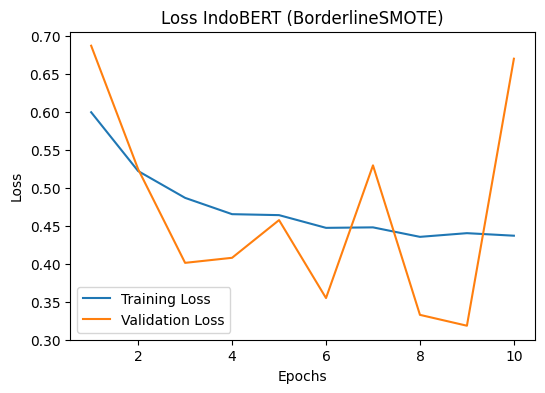

In [57]:
# Plot Loss
plt.figure(figsize=(6, 4))
train_loss = history_borderline.history['loss']
val_loss = history_borderline.history['val_loss']
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss IndoBERT (BorderlineSMOTE)')
plt.legend()
plt.show()

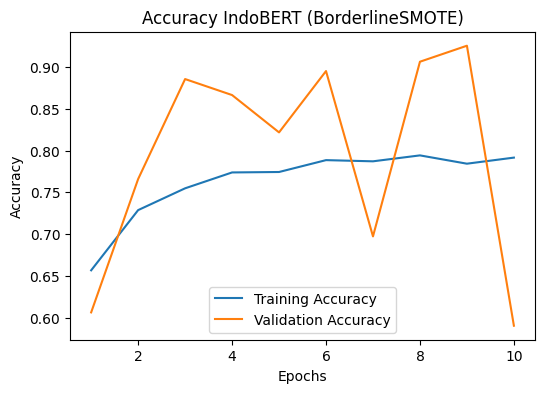

In [58]:
# Plot Accuracy
plt.figure(figsize=(6, 4))
train_accuracy = history_borderline.history['accuracy']
val_accuracy = history_borderline.history['val_accuracy']
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy IndoBERT (BorderlineSMOTE)')
plt.legend()
plt.show()

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


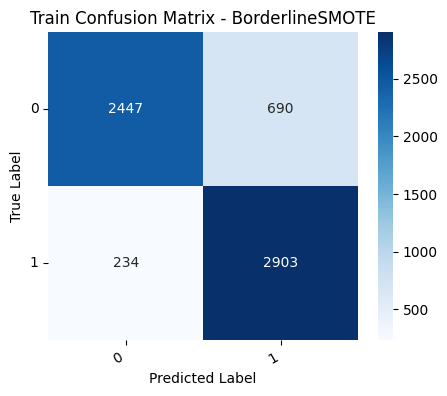

In [59]:
y_train_pred_border = (final_model_borderline.predict(x_train_np) > 0.5).astype("int32").flatten()
cm_train_border = confusion_matrix(y_train_np, y_train_pred_border)
show_confusion_matrix(cm_train_border, title="Train Confusion Matrix - BorderlineSMOTE")

<Figure size 500x400 with 0 Axes>

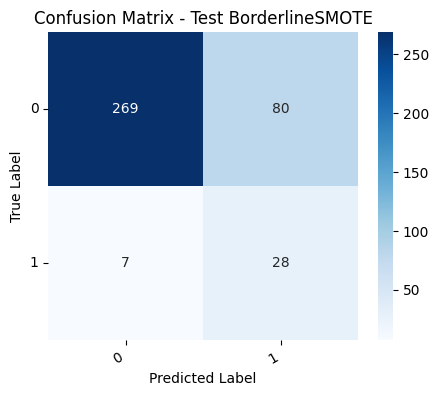

In [60]:
# Confusion Matrix
cm_border = confusion_matrix(y_test, y_test_pred_borderline)
plt.figure(figsize=(5, 4))
show_confusion_matrix(cm_border, title="Confusion Matrix - Test BorderlineSMOTE")

###KMeansSMOTE

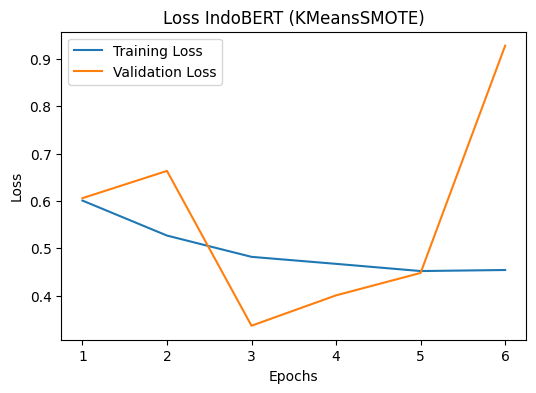

In [61]:
# Plot Loss
plt.figure(figsize=(6, 4))
train_loss = history_kmeans.history['loss']
val_loss = history_kmeans.history['val_loss']
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss IndoBERT (KMeansSMOTE)')
plt.legend()
plt.show()

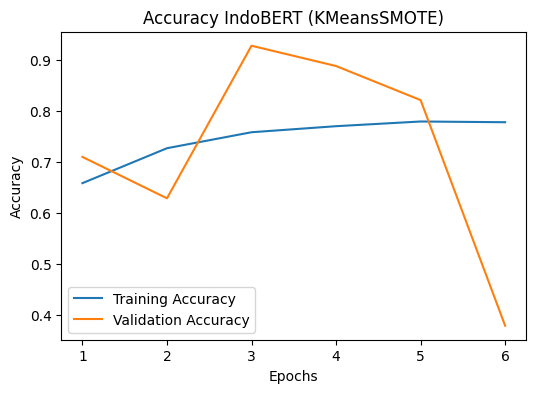

In [62]:
# Plot Accuracy
plt.figure(figsize=(6, 4))
train_accuracy = history_kmeans.history['accuracy']
val_accuracy = history_kmeans.history['val_accuracy']
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy IndoBERT (KMeansSMOTE)')
plt.legend()
plt.show()

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


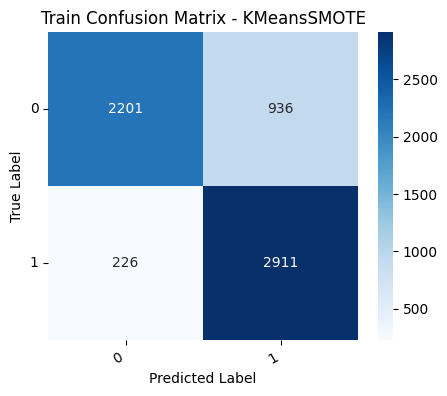

In [63]:
y_train_pred_kmeans = (final_model_kmeans.predict(x_train_np) > 0.5).astype("int32").flatten()
cm_train_kmeans = confusion_matrix(y_train_np, y_train_pred_kmeans)
show_confusion_matrix(cm_train_kmeans, title="Train Confusion Matrix - KMeansSMOTE")

<Figure size 500x400 with 0 Axes>

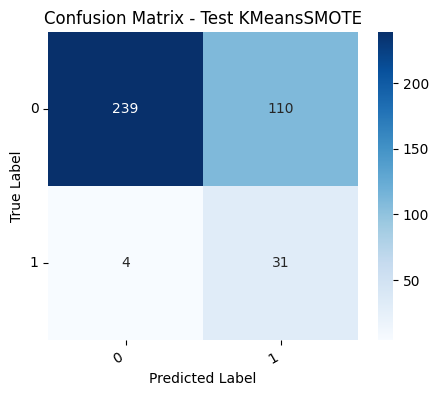

In [64]:
# Confusion Matrix
cm_kmeans = confusion_matrix(y_test, y_test_pred_kmeans)
plt.figure(figsize=(5, 4))
show_confusion_matrix(cm_kmeans, title="Confusion Matrix - Test KMeansSMOTE")

###SVMSMOTE

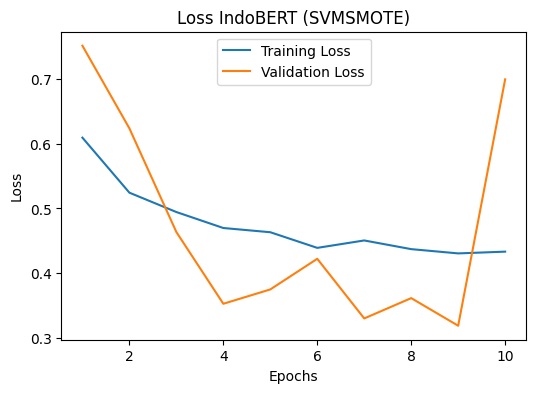

In [65]:
# Plot Loss
plt.figure(figsize=(6, 4))
train_loss = history_svm.history['loss']
val_loss = history_svm.history['val_loss']
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss IndoBERT (SVMSMOTE)')
plt.legend()
plt.show()

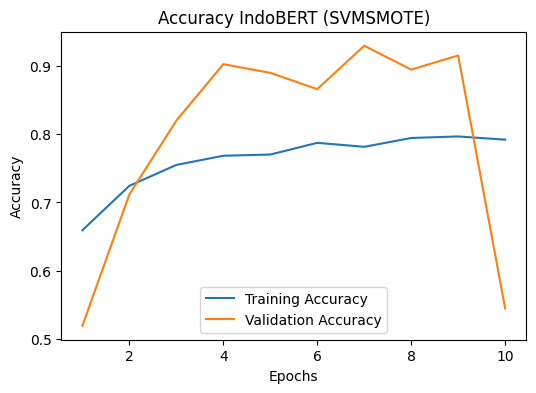

In [66]:
# Plot Accuracy
plt.figure(figsize=(6, 4))
train_accuracy = history_svm.history['accuracy']
val_accuracy = history_svm.history['val_accuracy']
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy IndoBERT (SVMSMOTE)')
plt.legend()
plt.show()

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


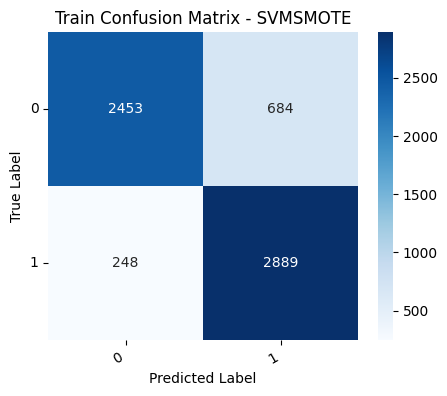

In [67]:
y_train_pred_svm = (final_model_svm.predict(x_train_np) > 0.5).astype("int32").flatten()
cm_train_svm = confusion_matrix(y_train_np, y_train_pred_svm)
show_confusion_matrix(cm_train_svm, title="Train Confusion Matrix - SVMSMOTE")

<Figure size 500x400 with 0 Axes>

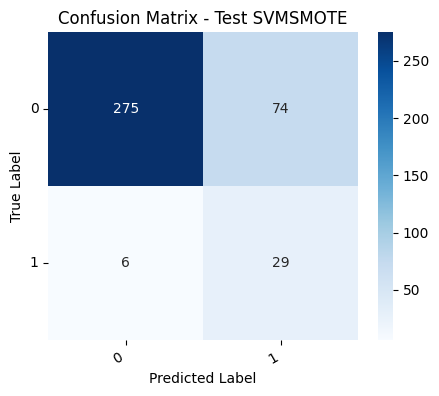

In [68]:
# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(5, 4))
show_confusion_matrix(cm_svm, title="Confusion Matrix - Test SVMSMOTE")